In [1]:
import matplotlib.pyplot as plt

"""
Small demo to illustrate how the plot function and the gridworld environment work
"""
import numpy as np
import optuna
from gridworld import *
from plot import *

In [2]:
def select_action(eps, decay,episode, state, q_table):
    # do random action
    if np.random.random() < eps/(decay*(episode+1)):
        return np.random.randint(0, len(q_table[0]))
    # or do best action
    else:
        return np.argmax(q_table[state])


In [36]:
def sarsa(env, alpha, gamma, episodes, max_episode_length, init_reward, eps, decay):
    #alpha = trial.suggest_float('ALPHA', 0,1)
    #gamma = trial.suggest_float('GAMMA', 0,1)
    #episodes = trial.suggest_int('EPISODES', 1,10000)
    #max_episode_length = trial.suggest_int('MAX_EPISODE_LENGTH', 1,2000)
    #init_reward = trial.suggest_int('INIT_REWARD', 0,20)
    #eps = trial.suggest_float('EPS', 0,1)
    #decay = trial.suggest_float('DECAY', 0,1)
    
    q_table = np.zeros((env.num_states(), env.num_actions()))
    q_table.fill(init_reward)
    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(episodes):
        state = env.reset()
        action = select_action(eps, decay,episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < max_episode_length:
            next_state, reward, done = env.step(action)
            next_action = select_action(eps, decay,episode, next_state, q_table)            
            
            # Q-Learning update rule
            delta = reward + gamma * q_table[next_state, next_action] * (done < 0.5) - q_table[state, action]
            q_table[state, action] += alpha * delta
            cum_reward += alpha * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return learning_data


In [37]:
def qlearning(env, alpha, gamma, episodes, max_episode_length, init_reward, eps, decay):
    q_table = np.zeros((env.num_states(), env.num_actions()))
    q_table.fill(init_reward)
    learning_data={}
    cum_reward = 0
    # run a certain number of episodes
    for episode in range(episodes):
        state = env.reset()
        action = select_action(eps, decay,episode, state, q_table)

        done = False
        episode_length = 0

        # run episode until a goal state or the maximum number of steps has been reached
        while not done and episode_length < max_episode_length:
            next_state, reward, done = env.step(action)
            next_action = select_action(eps, decay,episode, next_state, q_table)            
            
            # Q-Learning update rule
            delta = reward + gamma * np.max(q_table[next_state, next_action]) * (done < 0.5) - q_table[state, action]
            q_table[state, action] += alpha * delta
            cum_reward += alpha * delta
            
            state = next_state
            action = next_action
            episode_length += 1
            
        learning_data[episode] = [episode_length, cum_reward]

    return learning_data


In [28]:
def run_study():
    study = optuna.create_study(study_name='DRL_Studienarbeit1_A1_sarsa', storage='sqlite:///DRL_Studienarbeit1_A1_sarsa.db',load_if_exists=True, direction='maximize')
    study.optimize(sarsa, n_trials=3000)

In [29]:
run_study()

[I 2023-11-25 18:17:41,571] A new study created in RDB with name: DRL_Studienarbeit1_A1_sarsa
[I 2023-11-25 18:17:52,944] Trial 0 finished with value: -0.9295550436759891 and parameters: {'ALPHA': 0.7253849831724505, 'GAMMA': 0.8571272437557157, 'EPISODES': 8807, 'MAX_EPISODE_LENGTH': 430, 'INIT_REWARD': 9, 'EPS': 0.347371382068438, 'DECAY': 0.14054561664949783}. Best is trial 0 with value: -0.9295550436759891.
[I 2023-11-25 18:17:53,669] Trial 1 finished with value: -1.5334856524380882 and parameters: {'ALPHA': 0.24272876906795493, 'GAMMA': 0.5450963895211688, 'EPISODES': 4892, 'MAX_EPISODE_LENGTH': 1368, 'INIT_REWARD': 17, 'EPS': 0.23993868493681947, 'DECAY': 0.9533141037869134}. Best is trial 0 with value: -0.9295550436759891.
[I 2023-11-25 18:17:58,434] Trial 2 finished with value: -1.0035173271480122 and parameters: {'ALPHA': 0.7971757032487302, 'GAMMA': 0.6651464428920647, 'EPISODES': 3053, 'MAX_EPISODE_LENGTH': 331, 'INIT_REWARD': 0, 'EPS': 0.3922748793109463, 'DECAY': 0.8165815

KeyboardInterrupt: 

# Plot 1: Cumulative reward of the current episode over episodes

In [113]:
def plot_A1(qlearning_data, sarsa_data):
    qlearning_x_avg = np.zeros(len(qlearning_data))
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    
    for i in range(qlearning_data.keys().__len__()):
        qlearning_x = [value[1] for value in list(qlearning_data[i].values())]
    
        qlearning_x_avg = [sum(x) for x in zip(qlearning_x, qlearning_x_avg)]
        
        ax1.plot(range(len(qlearning_x)), qlearning_x, label='Env ' + str(i), alpha = 0.2)
    
    qlearning_x_avg = [a/10 for a in qlearning_x_avg]    
    ax1.plot(range(len(qlearning_data)),qlearning_x_avg, label="Average")
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Cumulative reward')
    ax1.title.set_text('Q-Learning Cumulative reward over episodes')
    ax1.set_ylim(min(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list)
)
    ax1.set_xlim(0,200)
    ax1.legend()
    
    #SARSA
    sarsa_x_avg = np.zeros(len(sarsa_data))

    for i in range(sarsa_data.keys().__len__()):
        sarsa_x = [value[1] for value in list(sarsa_data[i].values())]
    
        sarsa_x_avg = [sum(x) for x in zip(sarsa_x, sarsa_x_avg)]
        
        ax2.plot(range(len(sarsa_x)), sarsa_x, label='Env ' + str(i), alpha = 0.2)
    
    sarsa_x_avg = [a/10 for a in sarsa_x_avg]    
    ax2.plot(range(len(sarsa_data)),sarsa_x_avg, label="Average")
    
    
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative reward')
    ax2.title.set_text('SARSA Cumulative reward over episodes')
    ax2.set_ylim(min(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list))
    ax2.set_xlim(0,169)    
    ax2.legend()
    
    fig.tight_layout()
    plt.show()

In [59]:
#Hyperparameters found via optuna in DRL_Studienarbeit1_A1.db
#Optimized for cumulative reward/episode count
Q_ALPHA = 0.19119333605152306
Q_GAMMA =  0.999748200802963
Q_EPISODES = 200
Q_MAX_EPISODE_LENGTH = 42613
Q_INIT_REWARD = 4
Q_EPS = 0.01972098758840051
Q_DECAY = 0.7262144470920912

#SARSA
SARSA_ALPHA = 0.29746782448189185
SARSA_GAMMA = 0.9995697307876407
SARSA_EPISODES = 169
SARSA_MAX_EPISODE_LENGTH = 990
SARSA_INIT_REWARD = 0
SARSA_EPS = 0.9708745687550547
SARSA_DECAY = 0.44025244936731933

qlearning_data={}
sarsa_data={}
envs_A1 = []

for i in range(10):
    env = Random(size=12, water=0.3, mountain=0)
    envs_A1.append(env)        
    qlearning_data[i] = qlearning(env, Q_ALPHA, Q_GAMMA, Q_EPISODES, Q_MAX_EPISODE_LENGTH, Q_INIT_REWARD, Q_EPS, Q_DECAY)
    sarsa_data[i] = sarsa(env, SARSA_ALPHA, SARSA_GAMMA, SARSA_EPISODES, SARSA_MAX_EPISODE_LENGTH, SARSA_INIT_REWARD, SARSA_EPS, SARSA_DECAY)
    

In [110]:
min(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list)


-4233.73460812693

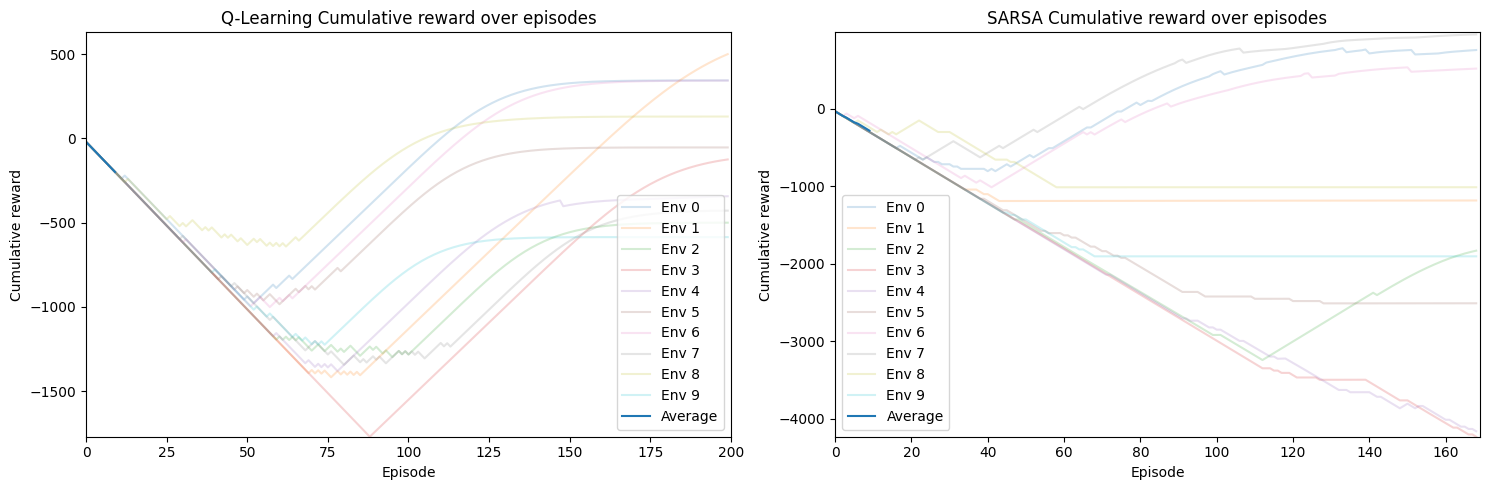

In [114]:
plot_A1(qlearning_data, sarsa_data)

# Plot 2: Cumulative reward over amount of steps

## Q-Learning

In [145]:
def plot_A2(qlearning_data, sarsa_data):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    qlearning_x_avg = np.zeros((Q_EPISODES))
    qlearning_y_avg = np.zeros((Q_EPISODES))
    for i in range(qlearning_data.keys().__len__()):
        qlearning_x = np.cumsum([value[0] for value in list(qlearning_data[i].values())])
        qlearning_y = np.cumsum([value[1] for value in list(qlearning_data[i].values())])
        
        qlearning_x_avg = [sum(x) for x in zip(qlearning_x, qlearning_x_avg)]
        
        qlearning_y_avg = [sum(y) for y in zip(qlearning_x, qlearning_y_avg)]
        
        ax1.plot(qlearning_x, qlearning_y, label='Env ' + str(i), alpha=0.2)
    
    qlearning_x_avg = [a/10 for a in qlearning_x_avg]
    qlearning_y_avg = [a/10 for a in qlearning_y_avg]
    
    ax1.plot(qlearning_x_avg, qlearning_y_avg, label="Average")
    
    # Adding labels and title
    ax1.set_xlabel('number of steps')
    ax1.set_ylabel('Cumulative reward')
    ax1.title.set_text('number of steps vs Cumulative reward')
    ax1.set_ylim(min(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in qlearning_data.values() for inner_list in inner_dict.values() for val in inner_list))
    ax1.set_xlim(0,9000)
    ax1.legend()
    
    #SARSA
    sarsa_x_avg = np.zeros((SARSA_EPISODES))
    sarsa_y_avg = np.zeros((SARSA_EPISODES))
    for i in range(sarsa_data.keys().__len__()):
        sarsa_x = np.cumsum([value[0] for value in list(sarsa_data[i].values())])
        sarsa_y = np.cumsum([value[1] for value in list(sarsa_data[i].values())])
        
        sarsa_x_avg = [sum(x) for x in zip(sarsa_x, sarsa_x_avg)]
        
        sarsa_y_avg = [sum(y) for y in zip(sarsa_x, sarsa_y_avg)]
        
        ax2.plot(sarsa_x, sarsa_y, label='Env ' + str(i), alpha=0.2)
    
    sarsa_x_avg = [a/10 for a in sarsa_x_avg]
    sarsa_y_avg = [a/10 for a in sarsa_y_avg]
    
    ax2.plot(sarsa_x_avg,sarsa_y_avg, label="Average")
    
    # Adding labels and title
    ax2.set_xlabel('number of steps')
    ax2.set_ylabel('Cumulative reward')
    ax2.title.set_text('number of steps vs Cumulative reward')
    ax2.set_ylim(min(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list), max(val for inner_dict in sarsa_data.values() for inner_list in inner_dict.values() for val in inner_list))
    ax2.set_xlim(0,9000)
    ax2.legend()
    
    plt.show()

In [132]:
#Hyperparameters found via optuna in DRL_Studienarbeit1_A2.db
#optimized for cumulative reward/episode length
Q_ALPHA = 0.6660010689218203
Q_GAMMA =  0.9955785729498876
Q_EPISODES = 11620
Q_MAX_EPISODE_LENGTH = 1544
Q_INIT_REWARD = 5
Q_EPS = 0.5579320801207901
Q_DECAY = 0.1763870404498077

#SARSA
SARSA_ALPHA= 0.8893905832326342
SARSA_GAMMA = 0.9998465053914064
SARSA_EPISODES = 3660
SARSA_MAX_EPISODE_LENGTH = 1002
SARSA_INIT_REWARD = 6
SARSA_EPS = 0.6983191701356518
SARSA_DECAY = 0.04701427863697144

qlearning_data_A2={}
sarsa_data_A2={}
envs2 = []

for i in range(10):
    env = Random(size=12, water=0, mountain=0.3)
    envs2.append(env)
    qlearning_data_A2[i] = qlearning(env, Q_ALPHA, Q_GAMMA, Q_EPISODES, Q_MAX_EPISODE_LENGTH, Q_INIT_REWARD, Q_EPS, Q_DECAY)
    sarsa_data_A2[i] = sarsa(env, SARSA_ALPHA, SARSA_GAMMA, SARSA_EPISODES, SARSA_MAX_EPISODE_LENGTH, SARSA_INIT_REWARD, SARSA_EPS, SARSA_DECAY)


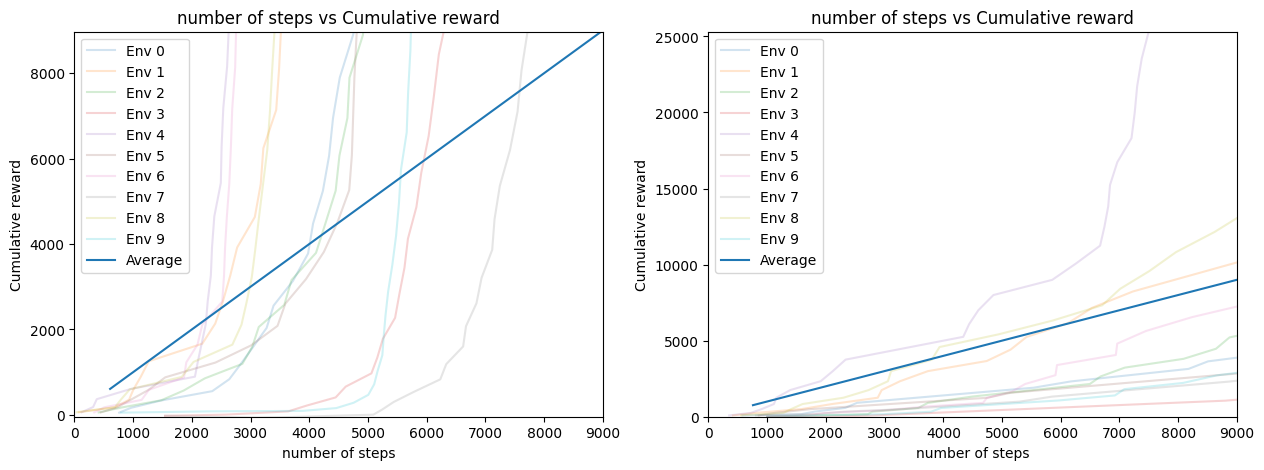

In [146]:
plot_A2(qlearning_data_A2, sarsa_data_A2)

 ## SARSA

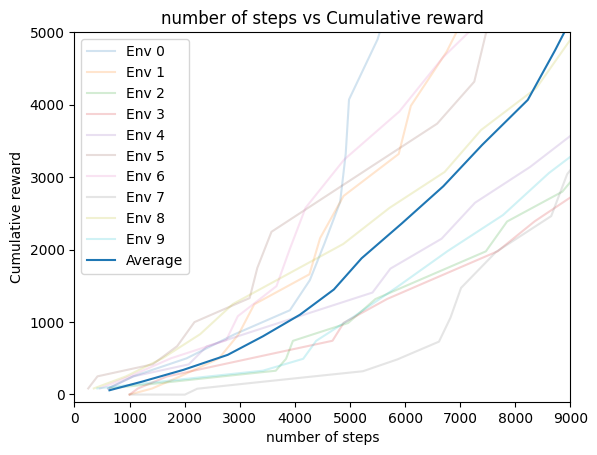

In [20]:
ALPHA= 0.8893905832326342
GAMMA = 0.9998465053914064
EPISODES = 3660
MAX_EPISODE_LENGTH = 1002
INIT_REWARD = 6
EPS = 0.6983191701356518
DECAY = 0.04701427863697144

data2={}
envs2 = []

for i in range(10):
    env = Random(size=12, water=0, mountain=0.3)
    envs2.append(env)
    data2[i] = sarsa(env, ALPHA, GAMMA, EPISODES, MAX_EPISODE_LENGTH, INIT_REWARD, EPS, DECAY)
    
plot_A2(data2)